Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до p-й, от p-й до 2*p-й, от 2*p-й до 3*p-й, .. .p*i-й до (i+1)*p -й,... ,от 9*p до 10*p-й точках (используйте осреденение точек, p - глубина истории, которую видим (в примере самая дальняя точка p=6))

Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [24]:
data_w = data.resample('W').mean()
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


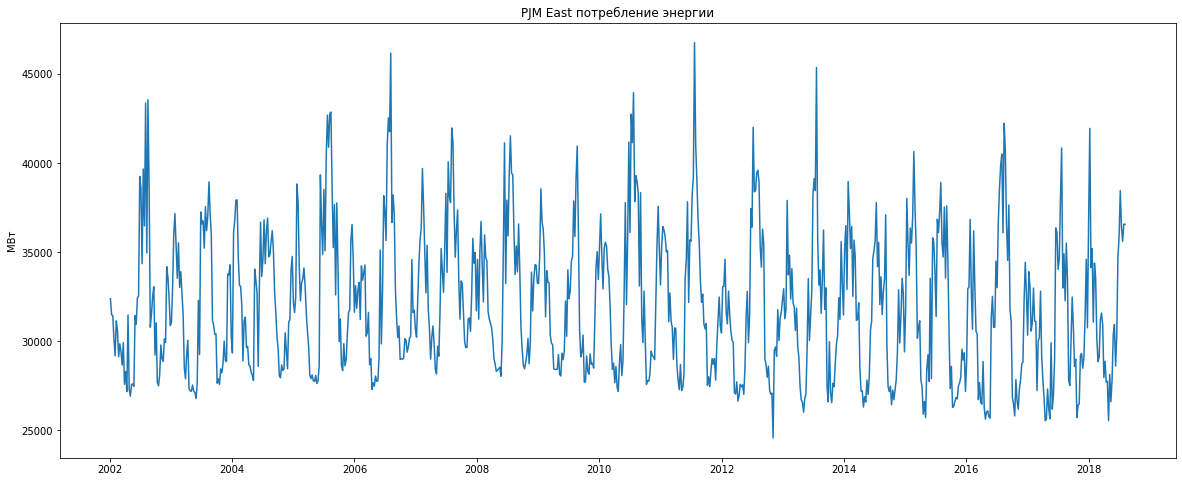

In [25]:
plt.figure(figsize = (20,8))
plt.plot(data_w['PJME_MW'])
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков 

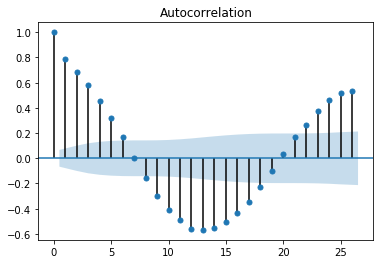

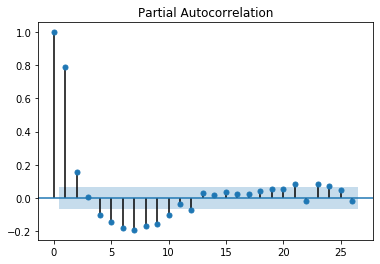

In [26]:

sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=26)
plt.show()
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=26)
plt.show()

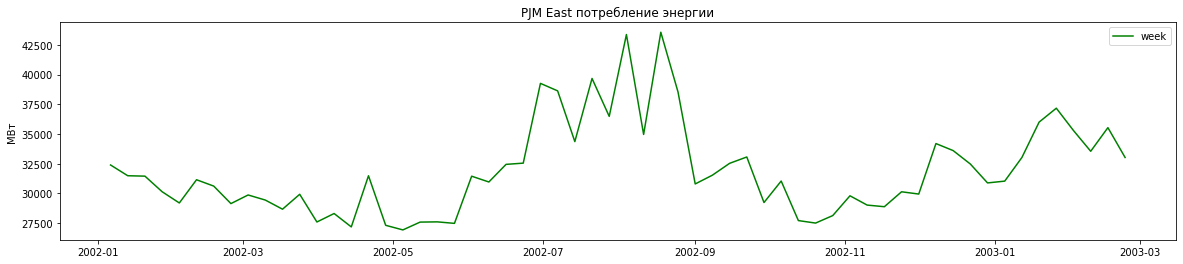

In [27]:
plt.figure(figsize =(20,4))
plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

Поскольку мы сделали ресемплинг данных по неделям, то допускаю, что можно удалить данные по дням, часам и неделям. 

In [28]:
data_w.drop(['year', 'hour', 'dayofmonth', 'dayofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday', 'is_next_holiday'], axis=1,inplace=True)
data_w.head()

,PJME_MW,month,quarter,weekofyear
Date,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0
2002-01-13,31487.386905,1.000000,1.0,2.0
2002-01-20,31452.880952,1.000000,1.0,3.0
2002-01-27,30141.529762,1.000000,1.0,4.0
2002-02-03,29196.488095,1.428571,1.0,5.0


In [29]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
import seaborn as sns

scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = data_w.iloc[:,:-1].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

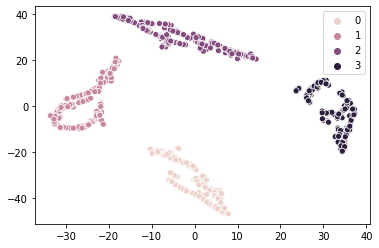

In [30]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

Отлично выделились кластеры с хорошим размещением объектов по группам. Принадлежность к кластерам можно использовать в качестве нового признака и проверить качество обработки модели с новой координатой.

In [33]:
data_w['week_month'] = X_clast
data_w.iloc[np.where(data_w['week_month']==0)[0]].iloc[:5,:]
data_w.iloc[np.where(data_w['week_month']==3)[0]].iloc[:5,:]

,PJME_MW,month,quarter,weekofyear,week_month
Date,,,,,
2002-10-06,31042.369048,9.857143,3.857143,40.0,3
2002-10-13,27714.601190,10.000000,4.000000,41.0,3
2002-10-20,27504.827381,10.000000,4.000000,42.0,3
2002-10-27,28137.335329,10.000000,4.000000,43.0,3
2002-11-03,29799.845238,10.428571,4.000000,44.0,3


In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
Xpca.shape

(866, 2)

In [35]:
data_w['pca1']=Xpca[:,0]
data_w['pca2']=Xpca[:,1]

Добавим к нашей модели 1-е разности.

In [36]:
first_diff =np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0
data_w['diff1'] =  data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = first_diff

Добавим логарифм признака

In [37]:
first_diff_l =np.log(data_w.iloc[1:,0].values) 
data_w['diff1_l'] = 0
data_w['diff1_l'] =  data_w['diff1_l'].astype('float') 
data_w['diff1_l'].values[1:] = first_diff_l